# 1. Utilities

## THIS IMPLEMENTATION USES THE A2C FROM GYMNASIUM https://gymnasium.farama.org/tutorials/gymnasium_basics/vector_envs_tutorial/

## 1.1 Imports


In [26]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C import A2C
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 Create Environment


In [24]:
# environment hyperparams
n_envs = 5
n_updates = 50000
n_steps_per_update = 2

#evaluation
evaluation_interval = 2000 #asked to be 20k steps
n_envs_eval = 5 #asked to be 10

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3

# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# environment setup
envs = gym.vector.make("CartPole-v1", num_envs=n_envs)


obs_shape = envs.single_observation_space.shape[0]
action_shape = envs.single_action_space.n

# set the device
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# init the agent
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

In [31]:
# create a wrapper environment to save episode returns and episode lengths
envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs * n_updates)

critic_losses = []
actor_losses = []
entropies = []
evaluation_returns = []
# use tqdm to get a progress bar for training
for sample_phase in tqdm(range(n_updates)):
    # we don't have to reset the envs, they just continue playing
    # until the episode is over and then reset automatically

    # reset lists that collect experiences of an episode (sample phase)
 
    ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device) 

    # at the start of training reset all envs to get an initial state
    if sample_phase == 0:
        states, info = envs_wrapper.reset(seed=42)

    # play n steps in our parallel environments to collect data
    for step in range(n_steps_per_update):
        # select an action A_{t} using S_{t} as input for the agent
        actions, action_log_probs, state_value_preds, entropy = agent.select_action(states, bool_greedy=False)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        states, rewards, terminated, truncated, infos = envs_wrapper.step(
            actions.cpu().numpy()
        )

        ep_value_preds[step] = torch.squeeze(state_value_preds)
        ep_rewards[step] = torch.tensor(rewards, device=device)
        ep_action_log_probs[step] = action_log_probs
        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        masks[step] = torch.tensor([not term for term in terminated]) # allows for correct bootstrapping

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        ep_rewards,
        ep_action_log_probs,
        ep_value_preds,
        entropy,
        masks,
        gamma,
        ent_coef,
        device,
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())

    #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
    #on a newly initialized environment and plotting the evaluation statistics below.
    if sample_phase % evaluation_interval == 0:
        print("EVALUATION")
        # evaluate
        returns = []
        episode_lengths = []
        for i in range(n_envs_eval):
            print(i)
            env_eval = gym.vector.make("CartPole-v1")
            print(i)
            state, info = env_eval.reset(seed=42)
            episode_return = 0
            episode_length = 0
            while True:
                action, _, _, _ = agent.select_action(state,bool_greedy=True)
                state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                episode_return += reward
                episode_length += 1
                if terminated or truncated:
                    break
            returns.append(episode_return)
            episode_lengths.append(episode_length)  
        evaluation_returns.append(np.mean(returns))



  0%|          | 0/50000 [00:00<?, ?it/s]

critic_loss tensor(0.5119, grad_fn=<MeanBackward0>)
actor_loss tensor(0.3607, grad_fn=<NegBackward0>)
EVALUATION
0


/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(


0
1
1
2
2
3
3
4
4
5
5
6
6
7


  0%|          | 0/50000 [00:09<?, ?it/s]


KeyboardInterrupt: 

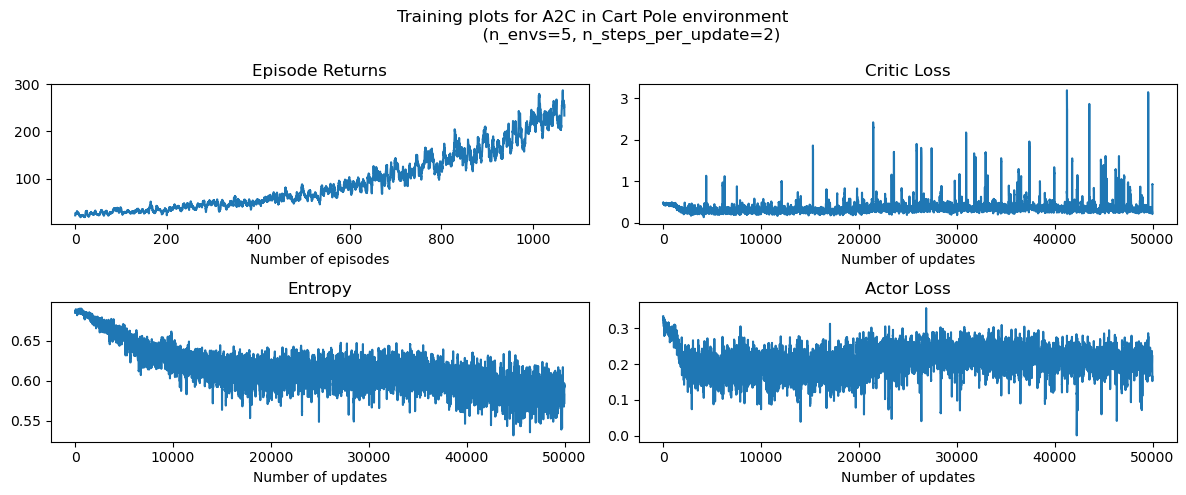

In [18]:
""" plot the results """

# %matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(
    f"Training plots for A2C in Cart Pole environment \n \
             (n_envs={n_envs}, n_steps_per_update={n_steps_per_update})"
)

# episode return
axs[0][0].set_title("Episode Returns")
episode_returns_moving_average = (
    np.convolve(
        np.array(envs_wrapper.return_queue).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)) / n_envs,
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

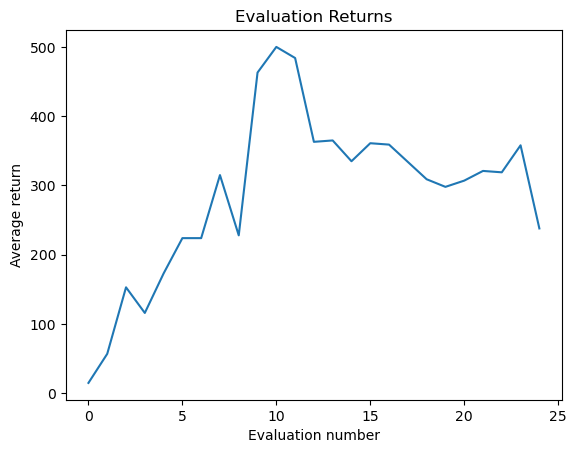

In [20]:
#plot evaluation
plt.plot(evaluation_returns)
plt.title("Evaluation Returns")
plt.xlabel("Evaluation number")
plt.ylabel("Average return")
plt.show()


### 1.2.1 Printing informations

In [5]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print("------")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

NameError: name 'env' is not defined

## 1.3 Define the A2C Class


# 2. Running the Agents (Discrete Case)


A2C.py and then we merge


In [ ]:
from A2C import *

## 1.4 Training function



train.py and then we merge


In [ ]:
from training import *

## 1.5 Evaluation functions

# 2. Running the Agents (Discrete Case)


## 2.1 Agent 1

# 3. Running the Agents (Continuous Case)
